In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.preprocessing import minmax_scale

In [ ]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

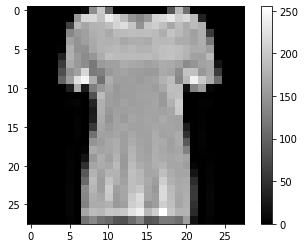

In [ ]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [ ]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

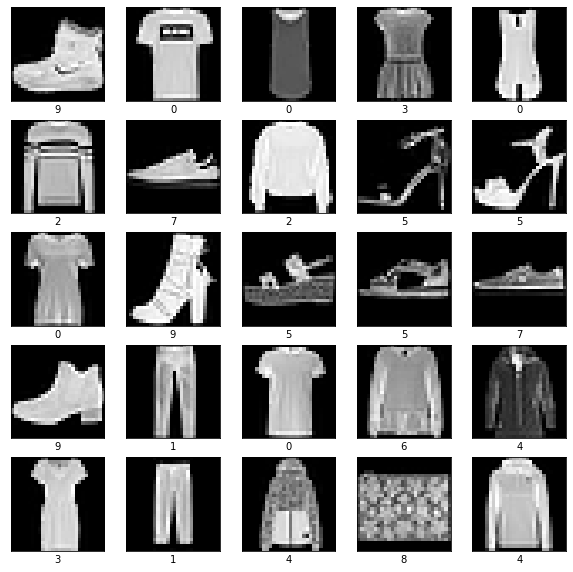

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

##**Seleccionar clases y filtrar**

###Clases seleccionadas 4 Coat, 6 shirt, 9 ankle boot


In [ ]:
#Seleccionar clases a utilizar y filtrar datos
train_labels_filter = np.where((train_labels == 4) | (train_labels==6) | (train_labels==9))
test_labels_filter = np.where((test_labels == 4) | (test_labels==6) | (test_labels==9))
train_images_filtered = np.take(train_images,train_labels_filter, axis=0)
train_labels_filtered = np.take(train_labels, train_labels_filter)
test_images_filtered = np.take(test_images,test_labels_filter, axis=0)
test_labels_filtered = np.take(test_labels,test_labels_filter)

train_images_filtered = train_images_filtered[0]
test_images_filtered = test_images_filtered[0]
train_labels_filtered = train_labels_filtered[0]
test_labels_filtered = test_labels_filtered[0]

#Transformar imagenes
train_images_filtered = train_images_filtered.reshape(len(train_images_filtered),28*28)
test_images_filtered = test_images_filtered.reshape(len(test_images_filtered),28*28)

#One hot-encoding
train_labels_filtered = pd.get_dummies(train_labels_filtered,
                         prefix="label",
                         drop_first=False).to_numpy()
test_labels_filtered = pd.get_dummies(test_labels_filtered,
                                      prefix="label",
                                      drop_first=False).to_numpy()



In [ ]:
#Creación del diccionario
dataDic = defaultdict(lambda: "Not Present")
dataDic["Coat"] = 4
dataDic["Shirt"] = 6
dataDic["Ankle boot"] = 9
print(dataDic)

defaultdict(<function <lambda> at 0x7f01807649e0>, {'Coat': 4, 'Shirt': 6, 'Ankle boot': 9})


In [ ]:
def accuracy(predictions, labels):
    correctly_predicted = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    accu = (100.0 * correctly_predicted) / predictions.shape[0]
    return accu

def ModeloSoftmax(train_dataset, train_labels,test_dataset,test_labels, num_features, num_labels, lr,batch_size,epochs, valid_dataset, valid_labels, scale):
  tf.reset_default_graph()
  with tf.name_scope("Identificar_cadena_de_configuracion"):
    now = datetime.now().strftime("%d%m%Y_%H%M%S")
    dateStr = f"{now}_lr={lr}_epochs={epochs}_batchSize={batch_size}_scale={scale}"
    
  with tf.name_scope("Definicion_entradas"):
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

  with tf.name_scope("Definicion_variables"):
    weights = tf.Variable(tf.truncated_normal([num_features, num_labels]),dtype=tf.float32)
    biases = tf.Variable(tf.zeros([num_labels]),dtype=tf.float32)

  with tf.name_scope("Entrenamiento"):
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

  with tf.name_scope("Optimizador"):
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)

  with tf.name_scope("Predicciones"):
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

  with tf.train.MonitoredSession() as session:
    writer = tf.summary.FileWriter('logs/'+dateStr,session.graph)
    
    for step in range(epochs):
        offset = np.random.randint(0, train_labels.shape[0] - batch_size - 1)
        offsetbs = offset + batch_size
        with tf.name_scope("Generar_mini_batch"):
          batch_data = train_dataset[offset:offsetbs,:]
          batch_labels = train_labels[offset:offsetbs,:]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        mini_accuracy = accuracy(predictions, batch_labels)
        summaryAcurracy = tf.Summary(value=[tf.Summary.Value(tag="MBAccuracy", simple_value=mini_accuracy)])
        summaryLoss = tf.Summary(value=[tf.Summary.Value(tag="Loss", simple_value=l)])
        writer.add_summary(summaryAcurracy, step)
        writer.add_summary(summaryLoss,step)
    return valid_prediction.eval(session=session)


In [ ]:
#Prueba de entramiento con datos sin escalar
randomSample = np.random.randint(0,len(train_images_filtered),5)
test_image_sample = train_images_filtered[randomSample]
test_labels_sample = train_labels_filtered[randomSample]
predict = ModeloSoftmax(np.float32(train_images_filtered),train_labels_filtered,np.float32(test_images_filtered),test_labels_filtered,784,3,0.01,32,500, np.float32(test_image_sample), test_labels_sample, False)



INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


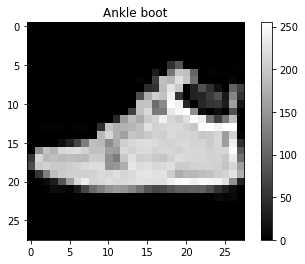

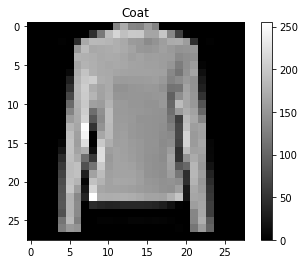

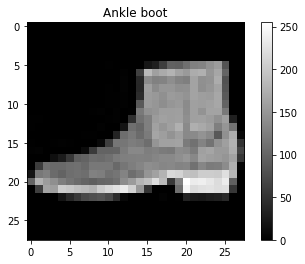

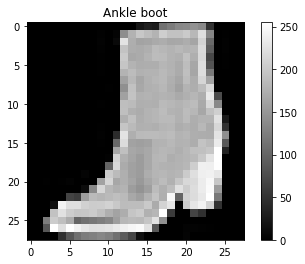

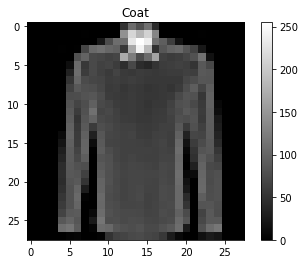

In [ ]:
##Imprimir imagenes y predicciones
test_image_sample_print = test_image_sample.reshape(5,28,28)
for i in range(0,5):
  name = list(dataDic.keys())[np.argmax(predict[i])]
  plt.imshow(test_image_sample_print[i], cmap = 'gray')
  plt.title(name)
  plt.colorbar()
  plt.show()


In [ ]:
#Prueba de entramiento con datos con escalamiento
randomSample = np.random.randint(0,len(train_images_filtered),5)
test_image_sample = train_images_filtered[randomSample]
test_labels_sample = train_labels_filtered[randomSample]

train_images_filtered_scaled = minmax_scale(train_images_filtered)
test_images_filtered_scaled = minmax_scale(test_images_filtered)
test_image_sample_scaled = minmax_scale(test_image_sample)
predict_scale = ModeloSoftmax(np.float32(train_images_filtered_scaled),train_labels_filtered,np.float32(test_images_filtered_scaled),test_labels_filtered,784,3,0.01,32,500, np.float32(test_image_sample_scaled), test_labels_sample, True)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


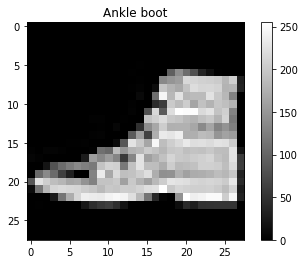

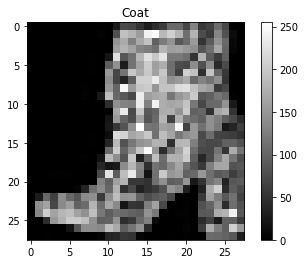

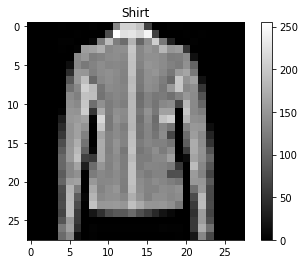

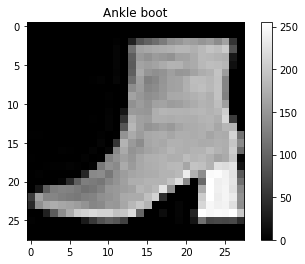

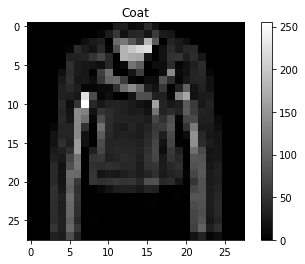

In [ ]:
##Imprimir imagenes y predicciones
test_image_sample_print = test_image_sample.reshape(5,28,28)
for i in range(0,5):
  name = list(dataDic.keys())[np.argmax(predict_scale[i])]
  plt.imshow(test_image_sample_print[i], cmap = 'gray')
  plt.title(name)
  plt.colorbar()
  plt.show()


##**Gráficas de experimento con datos crudos**

###**Loss**

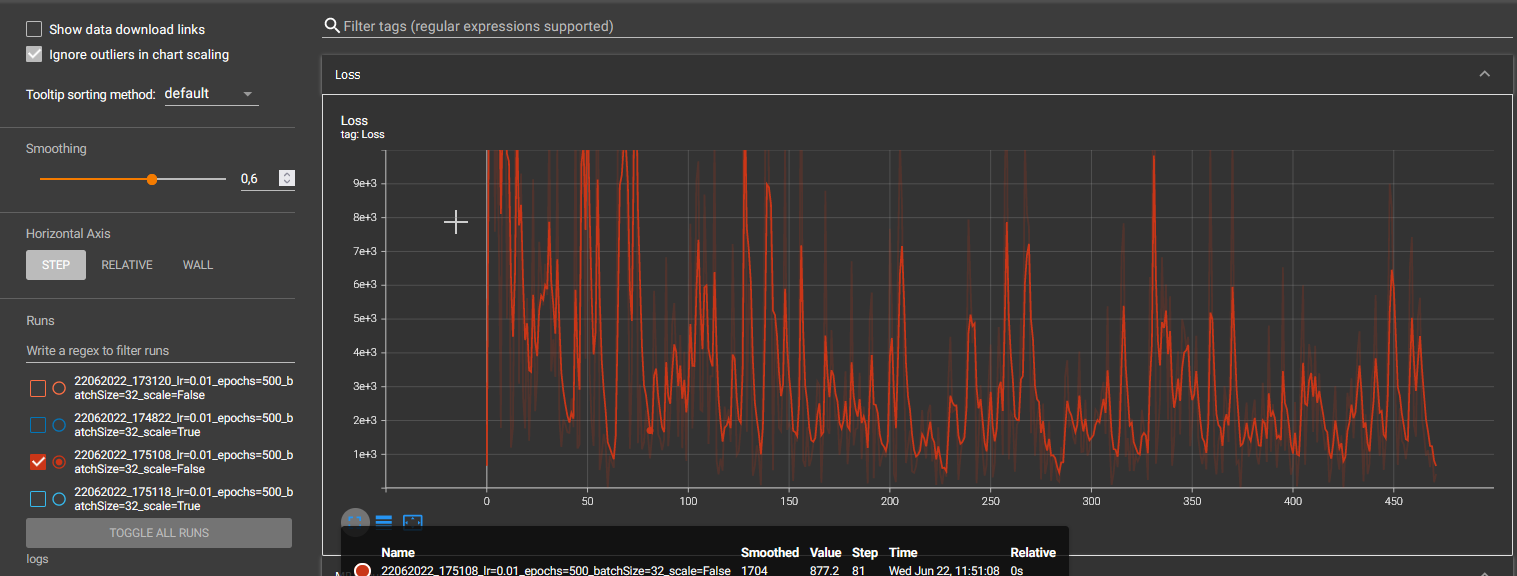

###**Accuracy**
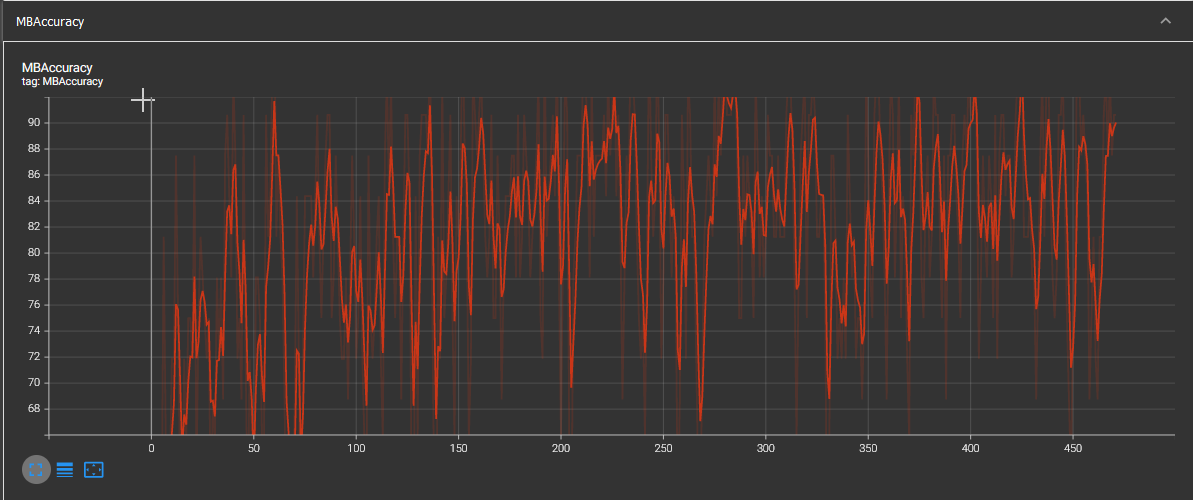



##**Gráficas de experimento con escalado**

###**Loss**

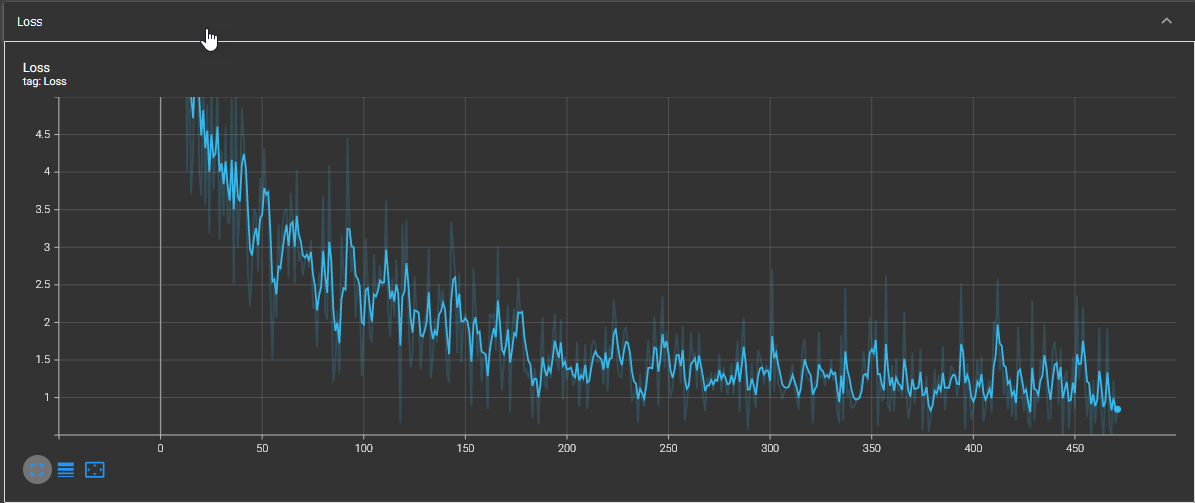

###**Accuracy**
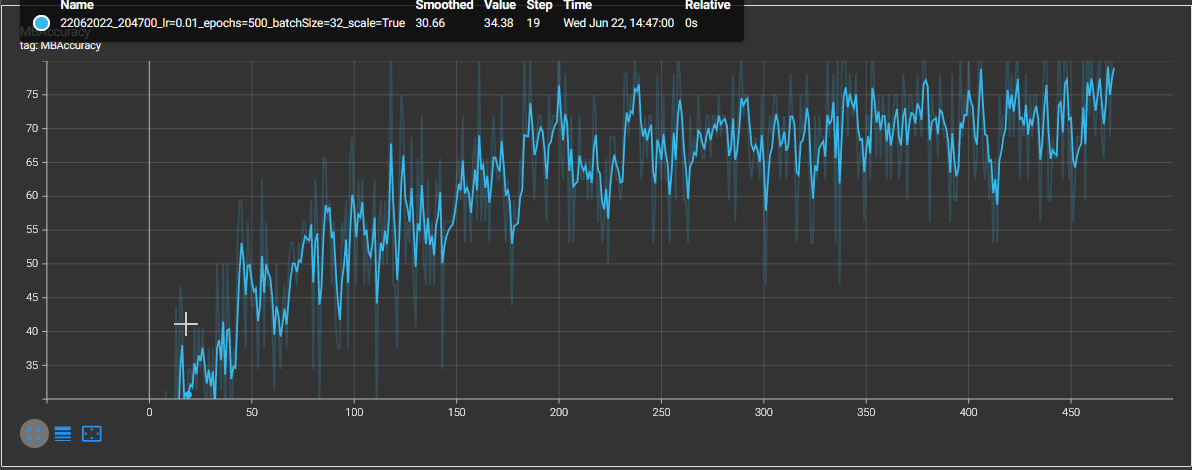



#**Grafo**
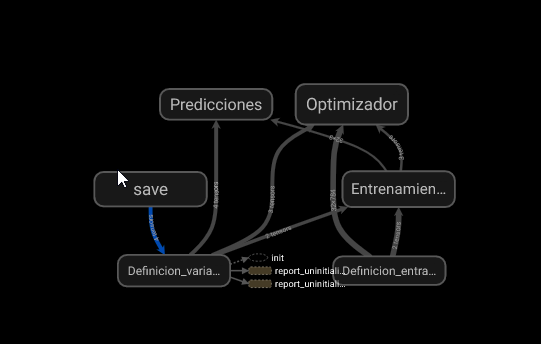

